In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight
import os
import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


## Cross-section functions

In [13]:
x0 = np.array([1,2,4,5,7,10])
#y0 = np.array([13.57,0.4238,0.01289,0.004156,0.0007452,0.000121])    ## old xsec 
y0     = np.array([8.492,0.2653,0.00809,2.612E-03,4.721E-04,7.751E-05])
x0_tau = np.array([1,2,4,7,10])
y0_tau = np.array([30700,963,17.9,0.646,0.0912])/1000.

def f_tau(x):
    x0_tau = np.array([1,2,4,7,10])
    y0_tau = np.array([30700,963,17.9,0.646,0.0912])/1000.    
    return np.exp(np.poly1d(np.polyfit(x0_tau,np.log(y0_tau),5))(x))

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys


(1e-06, 100.0)

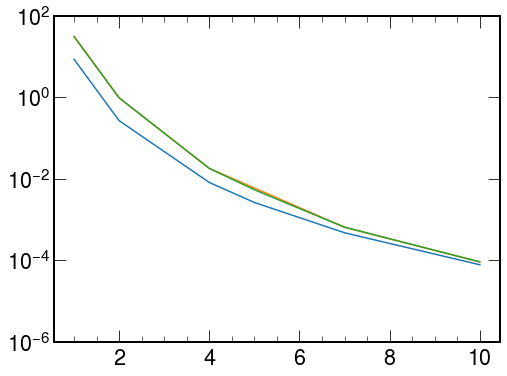

In [16]:
plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x0,y0)
ax.plot(x0_tau,y0_tau)
ax.plot(x0,f_tau(x0))
ax.set_yscale("log")
ax.set_ylim(1e-6,1e2)

# Loading limits

In [2]:
from HNLprocessor.util import f_xsec,f_xsec_tau
from HNLprocessor.util import f_v2,f_v2_tau

def loadLimits(f):
    T=uproot.open(f)['limit']
    return np.array(T['limit'].array())

def loadLimitFiles_tau(mass,fpath):
    arr =[]
    ctau = []
    for f in glob.glob(fpath):
        # f= "../limit/combine/HNL_datacards/muon_v1/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root"
        ct = f.split("/")[-1].split("_")[4].replace("pl","")
        xsec = f_xsec_tau(mass)(float(ct))
#         print(ct,xsec)    
        signalName = "_".join(f.split("/")[-1].split("_")[1:-1])   
#         card = os.path.dirname(f)+"/%s_CSC.txt"%signalName
#         norm = float(open(card,'r').readline().split()[-1])
        norm =1
        limit = loadLimits(f)
#        print(len(limit))
        if len(limit) !=6:
            print("Problem loading limit for ",signalName)
        else:
            arr.append(loadLimits(f)*xsec/norm)
            ctau.append(float(ct))        
#         arr.append(loadLimits(f)*xsec)
#         ctau.append(float(ct))
    arr = np.array(arr)
    ctau = np.array(ctau)
    return arr,ctau

import math
def plotlimit(ax,expected_CLs,poi_values,showBands = True, legend=True):

    # expected CLs
    if legend:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label=r"expected CL$_S$")
    else:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label='_nolegend_')        
        
    if showBands:
        # 1 and 2 sigma bands
        if legend:
            sigOnelabel = r"expected CL$_S$ $\pm 1\sigma$"
            sigTwolabel = r"expected CL$_S$ $\pm 2\sigma$"            
        else:
            sigOnelabel = '_nolegend_'
            sigTwolabel = '_nolegend_'
            
        ax.fill_between(
            poi_values,
            expected_CLs[:, 1],
            expected_CLs[:, 3],
            color="limegreen",
            label=sigOnelabel,
        )
        ax.fill_between(
            poi_values,
            expected_CLs[:, 0],
            expected_CLs[:, 4],
            color="yellow",
            label=sigTwolabel,
            zorder=0,  # draw beneath 1 sigma band
        )
    hep.cms.label(ax=ax,label="Preliminary",data=True,lumi="137")

    
    return ax

## find intersection of limit band with theory xsec
from scipy.optimize import fsolve

def intersect2(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return np.log(funcs[i](x))-np.log(xsec(x)) 
        return eq_i
    if isinstance(x0,int):
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

def intersect(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return funcs[i](x)-xsec(x) 
        return eq_i
    if isinstance(x0,int):
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

from scipy.interpolate import Rbf,interp1d
from scipy import interpolate
import numpy as np
def interpolate1D(combineLimits,x,nBins=10,f="linear"):
    epsilon = 0.2
    smooth = 1
#     nBins = 10
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = np.sort(x)
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    funcs=[]
    for i in range(5):
        y = combineLimits[:,i]
#         rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)
        if f=="linear":
            rbfi = interp1d(x, y,fill_value="extrapolate")
        else:
            rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)            

        yi = rbfi(xi)
        newLimits.append(yi)
        funcs.append(rbfi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, xi,funcs

def plotOneMass_fpath(fpath,label):
    mass = float(fpath.split("/")[-1].split("_")[2].replace("mHNL","").replace("p","."))            
    arr,ctau = loadLimitFiles_tau(mass,fpath)
    ax, func = plotOneMass_tau(arr,ctau,mass,r"$m_{HNL}^\tau=%.1fGeV$"%mass,True,None,True,label)
    return ax

def plotOneMass_tau(arr,ctau,mass,label,showBand=True,ax=None,addTheory=True,channel="Muon channel"):
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)

    plt.style.use(hep.style.CMS) 

    if ax ==None:
        fig, ax = plt.subplots(figsize=(8,6))
    ax = plotlimit(ax,arr_i,ctau_i,showBand)
    if addTheory:
        ax.plot(ctau_i,f_xsec_tau(mass)(ctau_i),label="Theory")

    ax.set_xlabel("ctau[mm]")
    ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend([label,"Theory"],title=channel)
    return ax,funcs

In [6]:
arr1GeV

array([[ 2.03773499,  3.04811192,  4.34716797,  6.42652775,  9.50441325,
         4.27178076],
       [ 1.09747839,  1.522098  ,  2.22979736,  3.42079831,  5.10064306,
         2.23892146],
       [ 6.01951599,  8.33590099, 12.32796875, 18.76528336, 28.05328382,
        12.31002855],
       [ 2.49593258,  3.45639863,  5.11166992,  7.80121386, 11.642283  ,
         5.09967382],
       [ 7.55367279, 10.4604205 , 15.46992187, 23.60954046, 35.23412503,
        15.45631057]])

In [5]:
ctau1GeV

array([ 100.,  800., 5000., 2000., 1000.])

[2084.00739237 1760.99003281 1436.02100204 1149.24081713  929.21915069]


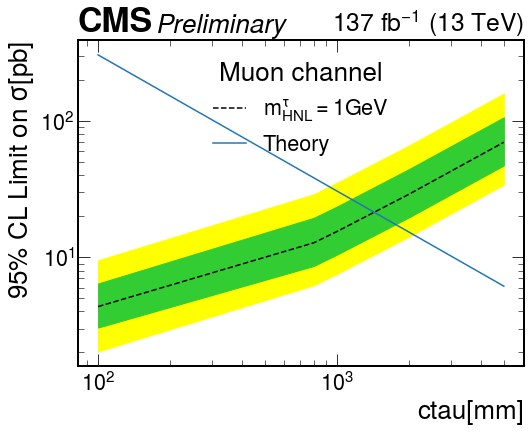

In [21]:
arr1GeV,ctau1GeV = loadLimitFiles_tau(1,"../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_HNL_tauTypeleptonFilter_mHNL1p0_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_1 = plotOneMass_tau(arr1GeV,ctau1GeV,1,r"$m_{HNL}^\tau=1GeV$",True)

ct_xing_1 = intersect(func_1,f_xsec_tau(1),200)
print(ct_xing_1)
# plt.savefig("./figures/result/AsymLimit_muon_4GeV.pdf")

[1269.61011684 1065.56975488  852.11210971  664.19267147  522.88388377]


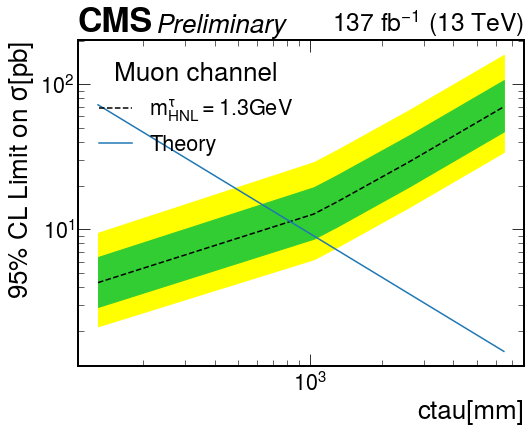

In [92]:
arr1p3GeV,ctau1p3GeV = loadLimitFiles_tau(1.3,"../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_HNL_tauTypeleptonFilter_mHNL1p3_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_1p3 = plotOneMass_tau(arr1p3GeV,ctau1p3GeV,1.3,r"$m_{HNL}^\tau=1.3GeV$",True)

ct_xing_1p3 = intersect(func_1p3,f_xsec_tau(1.3),200)
print(ct_xing_1p3)
# plt.savefig("./figures/result/AsymLimit_muon_4GeV.pdf")

In [15]:
arr1p3GeV

array([[ 14.21004559,  19.67824876,  29.10217336,  44.41450609,
         66.28279207,  29.09500081],
       [  7.54564436,  10.44930263,  15.45347965,  23.64604426,
         35.22771506,  15.46269869],
       [  6.23066437,   8.6283019 ,  12.76040063,  19.52524765,
         29.0885795 ,  12.78699311],
       [  2.15023325,   2.92297333,   4.30046651,   6.4603389 ,
          9.48440078,   4.30528014],
       [ 34.19223372,  47.34983266,  70.02569467, 106.87024992,
        159.48975131,  70.08970464]])

[492.18677158 354.70658333 241.69022467 159.32446818 107.99967237]


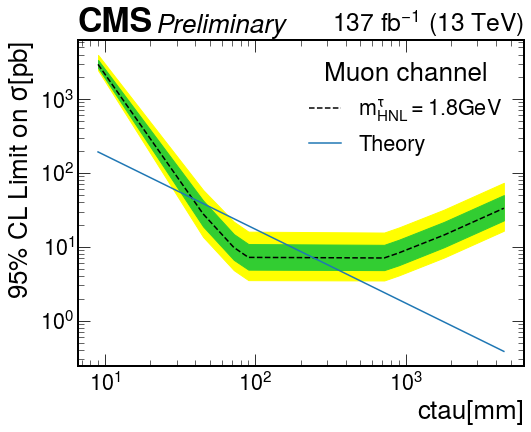

In [89]:
arr1p8GeV,ctau1p8GeV = loadLimitFiles_tau(1.8,"../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_HNL_tauTypeleptonFilter_mHNL1p8_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_1p8 = plotOneMass_tau(arr1p8GeV,ctau1p8GeV,1.8,r"$m_{HNL}^\tau=1.8GeV$",True)

ct_xing_1p8 = intersect(func_1p8,f_xsec_tau(1.8),200)
print(ct_xing_1p8)
# plt.savefig("./figures/result/AsymLimit_muon_4GeV.pdf")

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[272.30961892 196.23499611 133.7995395   99.99989321 100.00187923]


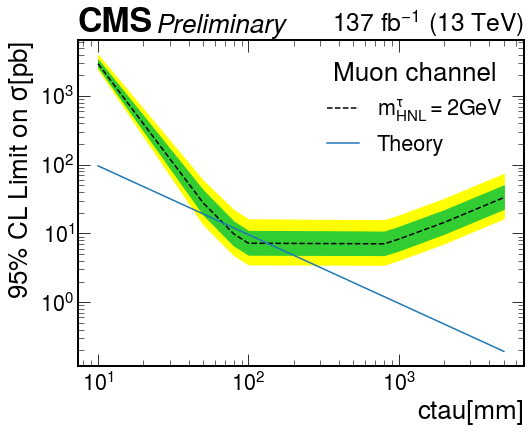

In [88]:
arr2GeV,ctau2GeV = loadLimitFiles_tau(2,"../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_HNL_tauTypeleptonFilter_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_2 = plotOneMass_tau(arr2GeV,ctau2GeV,2,r"$m_{HNL}^\tau=2GeV$",True)

ct_xing_2 = intersect(func_2,f_xsec_tau(2),200)
print(ct_xing_2)
# plt.savefig("./figures/result/AsymLimit_muon_4GeV.pdf")

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[157.7266681  103.84622174 109.99958547 109.9874438  110.04036925]


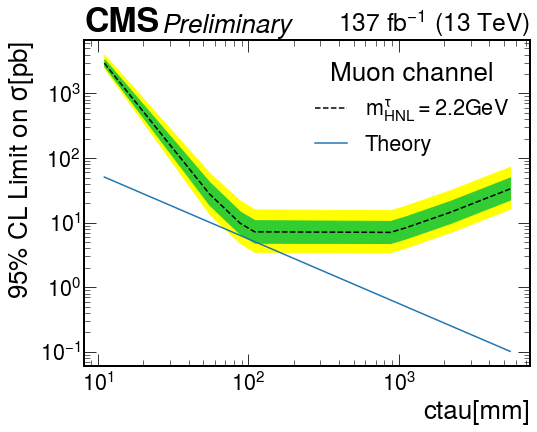

In [87]:
arr2p2GeV,ctau2p2GeV = loadLimitFiles_tau(2.2,"../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_HNL_tauTypeleptonFilter_mHNL2p2_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_2p2 = plotOneMass_tau(arr2p2GeV,ctau2p2GeV,2.2,r"$m_{HNL}^\tau=2.2GeV$",True)

ct_xing_2p2 = intersect(func_2p2,f_xsec_tau(2.2),200)
print(ct_xing_2p2)
# plt.savefig("./figures/result/AsymLimit_muon_4GeV.pdf")

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[125.00662974 125.01262989 125.02897963 125.02665524 125.7542986 ]


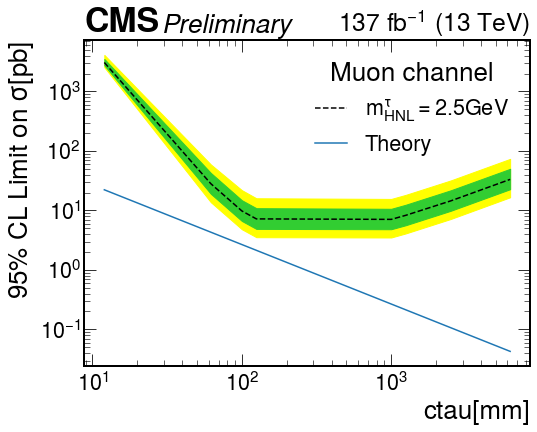

In [86]:
arr2p5GeV,ctau2p5GeV = loadLimitFiles_tau(2.5,"../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_HNL_tauTypeleptonFilter_mHNL2p5_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_2p5 = plotOneMass_tau(arr2p5GeV,ctau2p5GeV,2.5,r"$m_{HNL}^\tau=2.5GeV$",True)

ct_xing_2p5 = intersect(func_2p5,f_xsec_tau(2.5),200)
print(ct_xing_2p5)
# plt.savefig("./figures/result/AsymLimit_muon_4GeV.pdf")

# Electron channel

<AxesSubplot:xlabel='ctau[mm]', ylabel='95% CL Limit on $\\sigma$[pb]'>

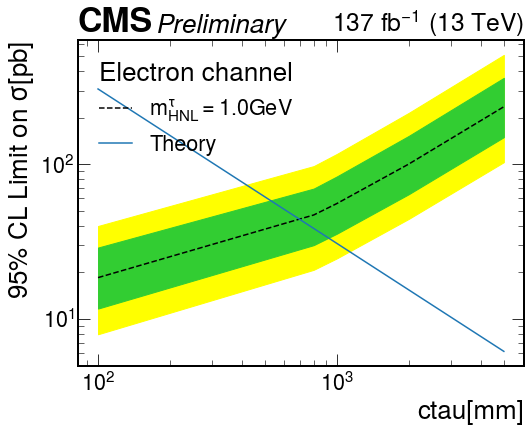

In [103]:
fpath=    f"{basedir}ele/higgsCombine_*_mHNL1p0_pl*_comb*.root"
plotOneMass_fpath(fpath,"Electron channel")

In [5]:
def get_ct_xing(mass,fpath,init_ct):
    ## get limit and ctau from path
    arr,ctau = loadLimitFiles_tau(mass,fpath)
    ## get iterpolated limit and ctau from path    
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)
    
    ct_xing = intersect(funcs,f_xsec_tau(mass),init_ct)
    return ct_xing

(5e-06, 10)

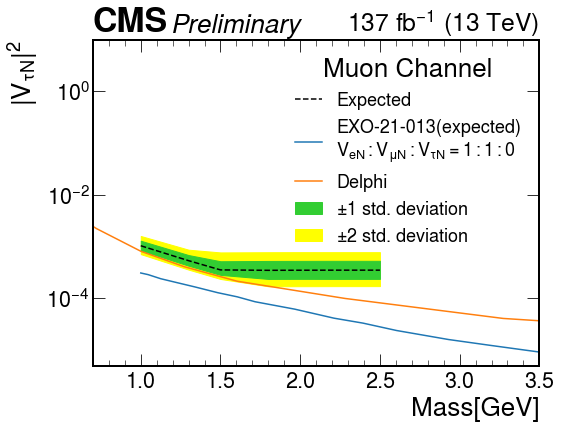

In [54]:
plt.style.use(hep.style.CMS) 

ct_xing_1 = intersect(func_1, f_xsec_tau(1),1000)
ct_xing_1p3 = intersect(func_1p3, f_xsec_tau(1.3),1000)
ct_xing_1p5 = intersect(func_1p5, f_xsec_tau(1.5),1000)
ct_xing_1p8 = intersect(func_1p8, f_xsec_tau(1.8),1000)
ct_xing_2   = intersect(func_2, f_xsec_tau(2),1000)
ct_xing_2p2 = intersect(func_2p2, f_xsec_tau(2.2),1000)

EXO = np.genfromtxt("../limit/otherHNLlimits/EXO-21-013_NmuTau.csv",delimiter=",")
Delphi = np.genfromtxt("../limit/otherHNLlimits/Delphi.csv",delimiter=",")

limits = np.array([f_v2_tau(1)(ct_xing_1),
                   f_v2_tau(1.3)(ct_xing_1p3),
                   f_v2_tau(1.5)(ct_xing_1p5),
                   f_v2_tau(1.8)(ct_xing_1p8),
                   f_v2_tau(2)(ct_xing_2),
                   f_v2_tau(2.2)(ct_xing_2p2), 
                   f_v2_tau(2.5)(ct_xing_2p5),                    
                  ])
masses = [1,1.3,1.5,1.8,2,2.2,2.5]

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits,masses)

ax.plot(EXO[:,0],EXO[:,1],label="EXO-21-013")
ax.plot(Delphi[:,0],Delphi[:,1],label="Delphi")
ax.legend(["Expected",
           'EXO-21-013(expected)\n'+r'$V_{eN}:V_{\mu N}:V_{\tau N}=1:1:0$',
           "Delphi",
           r"$\pm$1 std. deviation",
           r"$\pm$2 std. deviation"],
          loc=1,fontsize='x-small',
          title="Muon Channel")
# ax.legend()
ax.set_yscale("log")
ax.set_ylabel(r"$|V_{\tau N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,3.5)
ax.set_ylim(5e-6,10)

# fig.savefig("./figures/result/AsymLimit_VmuN_muon.pdf")

# Auto extraction

../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_*_mHNL1p0_pl*_comb*.root
../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_*_mHNL1p3_pl*_comb*.root
../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_*_mHNL1p5_pl*_comb*.root
../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_*_mHNL1p8_pl*_comb*.root
../limit/combine/HNL_datacards/tau_v1/mu/higgsCombine_*_mHNL2p0_pl*_comb*.root


/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(5e-06, 0.1)

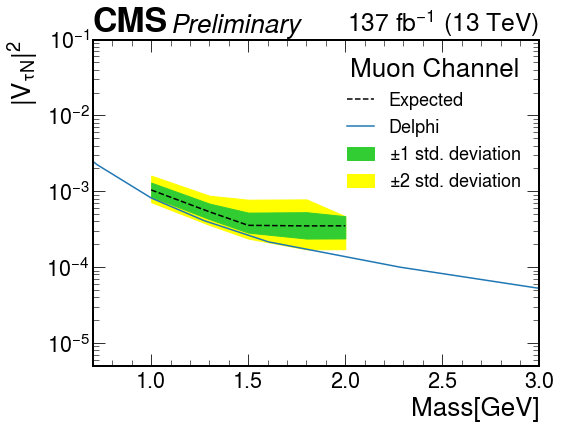

In [15]:
plt.style.use(hep.style.CMS) 

basedir="../limit/combine/HNL_datacards/tau_v1/"
fpaths=[
    f"{basedir}mu/higgsCombine_*_mHNL1p0_pl*_comb*.root",        
    f"{basedir}mu/higgsCombine_*_mHNL1p3_pl*_comb*.root",        
    f"{basedir}mu/higgsCombine_*_mHNL1p5_pl*_comb*.root",        
    f"{basedir}mu/higgsCombine_*_mHNL1p8_pl*_comb*.root",        
    f"{basedir}mu/higgsCombine_*_mHNL2p0_pl*_comb*.root",            
#     f"{basedir}mu/higgsCombine_*_mHNL2p2_pl*_comb*.root",                
#     f"{basedir}mu/higgsCombine_*_mHNL2p5_pl*_comb*.root",    
]

limits = []
masses = []
for fpath in fpaths:
    print(fpath)
    mass = float(fpath.split("/")[-1].split("_")[2].replace("mHNL","").replace("p","."))
    ct_xing = get_ct_xing(mass,fpath,1000)
    limits.append( f_v2_tau(mass)(ct_xing))
    masses.append(mass)
    
limits = np.array(limits)
masses = np.array(masses)
fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits,masses)

EXO = np.genfromtxt("../limit/otherHNLlimits/EXO-21-013_NmuTau.csv",delimiter=",")
Delphi = np.genfromtxt("../limit/otherHNLlimits/Delphi.csv",delimiter=",")

# ax.plot(EXO[:,0],EXO[:,1]*2,label="EXO-21-013")
ax.plot(Delphi[:,0],Delphi[:,1],label="Delphi")
ax.legend(["Expected",
#            'EXO-21-013(expected)\n'+r'$V_{eN}:V_{\mu N}:V_{\tau N}=0:1:1$',
           "Delphi",
           r"$\pm$1 std. deviation",
           r"$\pm$2 std. deviation"],
          loc=1,fontsize='x-small',
          title="Muon Channel")
# ax.legend()
ax.set_yscale("log")
ax.set_ylabel(r"$|V_{\tau N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,3)
ax.set_ylim(5e-6,1e-1)

# fig.savefig("./figures/result/AsymLimit_VmuN_muon.pdf")

../limit/combine/HNL_datacards/tau_v1/ele/higgsCombine_*_mHNL1p0_pl*_comb*.root
../limit/combine/HNL_datacards/tau_v1/ele/higgsCombine_*_mHNL1p3_pl*_comb*.root
../limit/combine/HNL_datacards/tau_v1/ele/higgsCombine_*_mHNL1p5_pl*_comb*.root
../limit/combine/HNL_datacards/tau_v1/ele/higgsCombine_*_mHNL1p8_pl*_comb*.root


/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


../limit/combine/HNL_datacards/tau_v1/ele/higgsCombine_*_mHNL2p0_pl*_comb*.root


(5e-06, 0.1)

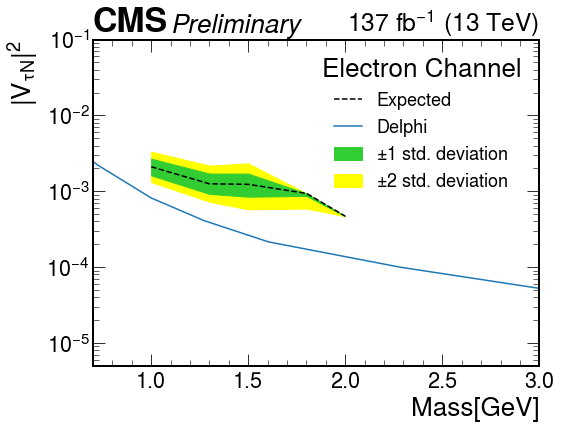

In [14]:
plt.style.use(hep.style.CMS) 

basedir="../limit/combine/HNL_datacards/tau_v1/"
fpaths=[
    f"{basedir}ele/higgsCombine_*_mHNL1p0_pl*_comb*.root",        
    f"{basedir}ele/higgsCombine_*_mHNL1p3_pl*_comb*.root",        
    f"{basedir}ele/higgsCombine_*_mHNL1p5_pl*_comb*.root",        
    f"{basedir}ele/higgsCombine_*_mHNL1p8_pl*_comb*.root",        
    f"{basedir}ele/higgsCombine_*_mHNL2p0_pl*_comb*.root",            
#     f"{basedir}mu/higgsCombine_*_mHNL2p2_pl*_comb*.root",                
#     f"{basedir}mu/higgsCombine_*_mHNL2p5_pl*_comb*.root",    
]

limits = []
masses = []
for fpath in fpaths:
    print(fpath)
    mass = float(fpath.split("/")[-1].split("_")[2].replace("mHNL","").replace("p","."))
    ct_xing = get_ct_xing(mass,fpath,100)
    limits.append( f_v2_tau(mass)(ct_xing))
    masses.append(mass)
    
limits = np.array(limits)
masses = np.array(masses)
fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits,masses)

EXO = np.genfromtxt("../limit/otherHNLlimits/EXO-21-013_NeTau_expected.csv",delimiter=",")
# Delphi = np.genfromtxt("../limit/otherHNLlimits/Delphi.csv",delimiter=",")

# ax.plot(EXO[:,0],EXO[:,1]*2,label="EXO-21-013")
ax.plot(Delphi[:,0],Delphi[:,1],label="Delphi")
ax.legend(["Expected",
#            'EXO-21-013(expected)\n'+r'$V_{eN}:V_{\mu N}:V_{\tau N}=1:0:1$',
           "Delphi",
           r"$\pm$1 std. deviation",
           r"$\pm$2 std. deviation"],
          loc=1,fontsize='x-small',
          title="Electron Channel")
# ax.legend()
ax.set_yscale("log")
ax.set_ylabel(r"$|V_{\tau N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,3)
ax.set_ylim(5e-6,1e-1)

# fig.savefig("./figures/result/AsymLimit_VmuN_muon.pdf")

### Combination (Ele+Mu)

1.0 [2155.1928416  1824.92255395 1490.48723372 1193.85483355  966.47456703]
1.3 [1311.00804679 1102.27127095  884.98294514  691.99117062  545.91505641]
1.5 [971.21820194 811.90164114 653.12834413 458.79996542 310.85862123]
1.8 [523.44788535 378.81141287 258.5899351  171.39693674 116.12221389]


/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


2.0 [290.6650015  209.83262547 143.16471663 100.         100.        ]


(5e-05, 0.1)

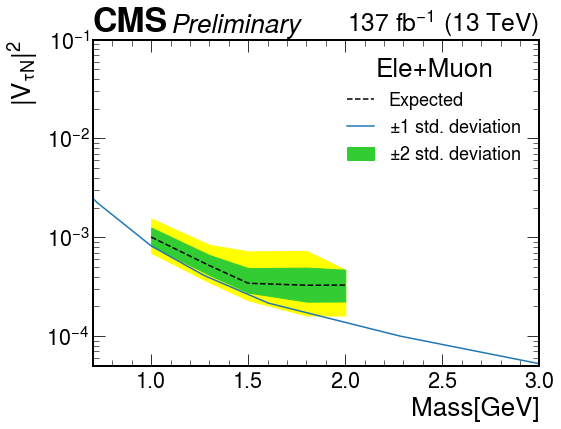

In [13]:
plt.style.use(hep.style.CMS) 

basedir="../limit/combine/HNL_datacards/tau_v1/"
fpaths=[
    f"{basedir}higgsCombine_*_mHNL1p0_pl*_comb*.root",        
    f"{basedir}higgsCombine_*_mHNL1p3_pl*_comb*.root",        
    f"{basedir}higgsCombine_*_mHNL1p5_pl*_comb*.root",        
    f"{basedir}higgsCombine_*_mHNL1p8_pl*_comb*.root",        
    f"{basedir}higgsCombine_*_mHNL2p0_pl*_comb*.root",            
#     f"{basedir}mu/higgsCombine_*_mHNL2p2_pl*_comb*.root",                
#     f"{basedir}mu/higgsCombine_*_mHNL2p5_pl*_comb*.root",    
]

limits = []
masses = []
for fpath in fpaths:
#     print(fpath)
    mass = float(fpath.split("/")[-1].split("_")[2].replace("mHNL","").replace("p","."))
    ct_xing = get_ct_xing(mass,fpath,100)
    print(mass,ct_xing)
    limits.append( f_v2_tau(mass)(ct_xing))
    masses.append(mass)
    
limits = np.array(limits)
masses = np.array(masses)
fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits,masses)

EXO_ele = np.genfromtxt("../limit/otherHNLlimits/EXO-21-013_NeTau_expected.csv",delimiter=",")
EXO_mu = np.genfromtxt("../limit/otherHNLlimits/EXO-21-013_NmuTau.csv",delimiter=",")
Delphi = np.genfromtxt("../limit/otherHNLlimits/Delphi.csv",delimiter=",")

ax.plot(Delphi[:,0],Delphi[:,1],label="Delphi")
# ax.plot(EXO_ele[:,0],EXO_ele[:,1]*2,label="EXO-21-013")
# ax.plot(EXO_mu[:,0],EXO_mu[:,1]*2,label="EXO-21-013")

ax.legend(["Expected",
#            'EXO-21-013(expected)\n'+r'$V_{eN}:V_{\mu N}:V_{\tau N}=1:0:1$',
#            'EXO-21-013(expected)\n'+r'$V_{eN}:V_{\mu N}:V_{\tau N}=0:1:1$',           
           r"$\pm$1 std. deviation",
           r"$\pm$2 std. deviation"],
          loc=1,fontsize='x-small',
          title="Ele+Muon")
# ax.legend()
ax.set_yscale("log")
ax.set_ylabel(r"$|V_{\tau N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,3)
ax.set_ylim(5e-5,1e-1)

# fig.savefig("./figures/result/AsymLimit_VmuN_muon.pdf")

In [106]:
fpath = f"{basedir}higgsCombine_*_mHNL1p8_pl*_comb*.root"
mass = 1.8
ct_xing = get_ct_xing(mass,fpath,100)
print(mass,ct_xing)


1.8 [523.44788535 378.81141287 258.5899351  171.39693674 116.12221389]


<AxesSubplot:xlabel='ctau[mm]', ylabel='95% CL Limit on $\\sigma$[pb]'>

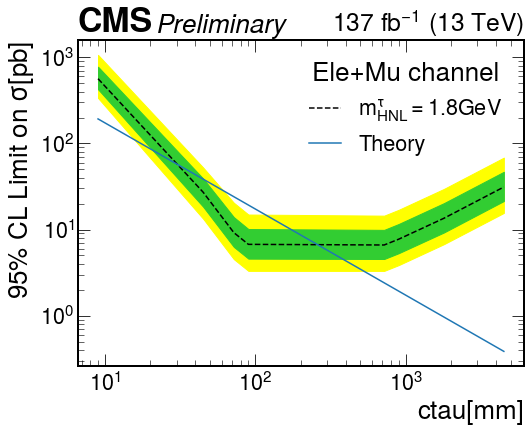

In [107]:
fpath=    f"{basedir}/higgsCombine_*_mHNL1p8_pl*_comb*.root"
plotOneMass_fpath(fpath,'Ele+Mu channel')

<AxesSubplot:xlabel='ctau[mm]', ylabel='95% CL Limit on $\\sigma$[pb]'>

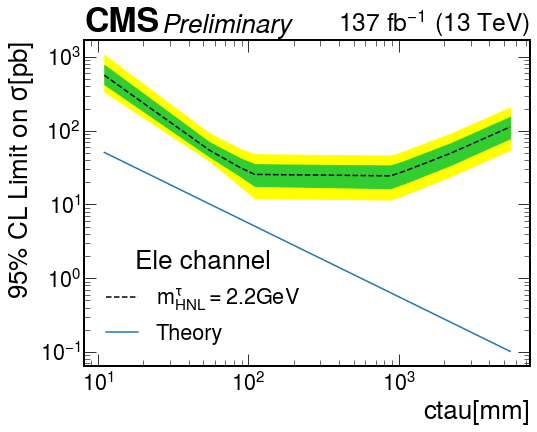

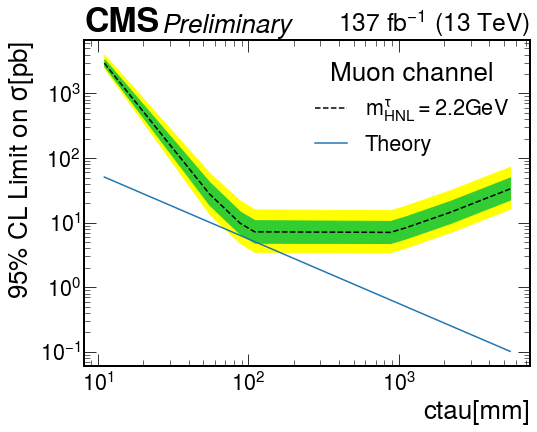

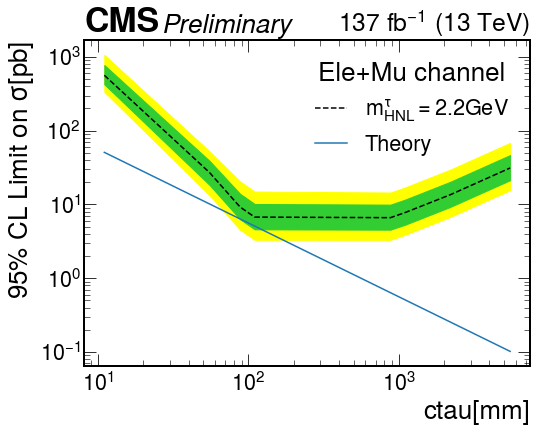

In [119]:
fpath=    f"{basedir}/ele/higgsCombine_*_mHNL2p2_pl*_comb*.root"
plotOneMass_fpath(fpath,'Ele channel')
fpath=    f"{basedir}/mu/higgsCombine_*_mHNL2p2_pl*_comb*.root"
plotOneMass_fpath(fpath,'Muon channel')
fpath=    f"{basedir}/higgsCombine_*_mHNL2p2_pl*_comb*.root"
plotOneMass_fpath(fpath,'Ele+Mu channel')
